# Laboratorio 11

- Joaquín Puente 22296
- José Mérida

## Inicialización de PySpark

In [998]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import (
    col, count, when, isnan, isnull, mean, stddev, countDistinct,
    min as spark_min, max as spark_max, round as spark_round
)
from pyspark.sql.types import DoubleType, IntegerType
import os

spark = SparkSession.builder \
    .appName("Customer Churn Analysis - Lab 11") \
    .config("spark.driver.memory", "4g") \
    .getOrCreate()

spark.sparkContext.setLogLevel("ERROR")

print("Spark Session iniciada exitosamente!")
print(f"Versión de Spark: {spark.version}")

Spark Session iniciada exitosamente!
Versión de Spark: 4.0.1


## Carga y Descripción de los Datos
En este inciso, vamos a cargar los datos del archivo CSV y dar un vistazo general.

### Carga y Visualización Esquema
Primero, utilizamos la lectura de CSV con inferSchema y header como True para cargar el conjunto de datos con los nombres de columna y tipos de datos correctos.

In [999]:
df = spark.read.csv("data/abandono_clientes.csv", header=True, inferSchema=True)
df_nuevos = spark.read.csv("data/clientes_nuevos.csv", header=True, inferSchema=True)

print(f"Dataset 'abandono_clientes' cargado: {df.count()} filas")
print(f"Dataset 'clientes_nuevos' cargado: {df_nuevos.count()} filas")

Dataset 'abandono_clientes' cargado: 900 filas
Dataset 'clientes_nuevos' cargado: 6 filas


Podemos ver que ambos datasets fueron cargados exitosamente, ahora podemos tomar un vistazo a sus esquemas.

**Abandono Clientes**

In [1000]:
df.printSchema()

root
 |-- Names: string (nullable = true)
 |-- Age: double (nullable = true)
 |-- Total_Purchase: double (nullable = true)
 |-- Account_Manager: integer (nullable = true)
 |-- Years: double (nullable = true)
 |-- Num_Sites: double (nullable = true)
 |-- Onboard_date: timestamp (nullable = true)
 |-- Location: string (nullable = true)
 |-- Company: string (nullable = true)
 |-- Churn: integer (nullable = true)



**Clientes Nuevos**

In [1001]:
df_nuevos.printSchema()

root
 |-- Names: string (nullable = true)
 |-- Age: double (nullable = true)
 |-- Total_Purchase: double (nullable = true)
 |-- Account_Manager: integer (nullable = true)
 |-- Years: double (nullable = true)
 |-- Num_Sites: double (nullable = true)
 |-- Onboard_date: timestamp (nullable = true)
 |-- Location: string (nullable = true)
 |-- Company: string (nullable = true)



Observando algos esquemas, podemos darnos cuenta que los "clientes nuevos" son los que buscamos predecir con nuestros modelos. Mientras que "Abandono Clientes" es el dataset sobre el cual vamos a entrenar y testear nuestros modelos. Ya que la única columna de diferencia es Churn. Adicionalmente, podemos proveer una breve descripción de las variables basado en información proveída para el proyecto de consultoría:

- Name: String, nombre del contacto más reciente en la compañia
- Edad: Numérico, la edad del cliente.
- Total_Purchaes: Numérico, la cantidad de anuncios adquiridos.
- Account_Manager: Categórica / Binario, 0 = No tienen gerente y 1 = Gerente de cuenta asignado.
- Years: Numérico, total de años como cliente.
- Num_Sites: Numérico, cantidad de sitios que usan este servicio.
- Onboard_date: Fecha de abordaje del contacto más reciente.
- Location: String, ubicación central de la compañía.
- Comopany: Nombre de la compañía
- Churn: Binario, 0 o 1 indicando si el cliente abandonó (1) o no (0)

**Primeras Filas**

In [1002]:
df.show(10)

+----------------+----+--------------+---------------+-----+---------+-------------------+--------------------+--------------------+-----+
|           Names| Age|Total_Purchase|Account_Manager|Years|Num_Sites|       Onboard_date|            Location|             Company|Churn|
+----------------+----+--------------+---------------+-----+---------+-------------------+--------------------+--------------------+-----+
|Cameron Williams|42.0|       11066.8|              0| 7.22|      8.0|2013-08-30 07:00:40|10265 Elizabeth M...|          Harvey LLC|    1|
|   Kevin Mueller|41.0|      11916.22|              0|  6.5|     11.0|2013-08-13 00:38:46|6157 Frank Garden...|          Wilson PLC|    1|
|     Eric Lozano|38.0|      12884.75|              0| 6.67|     12.0|2016-06-29 06:20:07|1331 Keith Court ...|Miller, Johnson a...|    1|
|   Phillip White|42.0|       8010.76|              0| 6.71|     10.0|2014-04-22 12:43:12|13120 Daniel Moun...|           Smith Inc|    1|
|  Cynthia Norton|37.0|    

Viendo las primeras filas, podemos darnos cuenta de lo siguiente:

- La columna de nombre realmente nos es indiferente para construir modelos de ML, esta no nos provee información relevante para la regresión.
- La fecha de onboarding contiene información de la hora, esta información podría estár un poco de más y podríamos transformarla a únicamente utilizar el día
- La ubicación consta de una dirección entera, esto realmente no nos es útil para modelos de ML. Podemos transformar esta variable para intentar categorizar por estado, ciudad, etc.

De momento, únicamente vamos a remover la columna de Names y vamos a proceder con demás transformaciones de datos durante el EDA.

In [1003]:
# Remover columna de Names
df = df.drop("Names")

df_nuevos = df_nuevos.drop("Names")

## Limpieza Básica
En esta sección vamos a realizar operaciones de limpieza básica sobre los datasets, buscando dejar la información lo más consistente posible para realizar un EDA de calidad. Adicionalmente, algunas de las operaciones de verificación de nulos / duplicados podemos evitarlas para el dataset de nuevos clientes ya que contiene una pequeña cantidad de datos. Es más eficiente realizar este tipo de checks de manera "manual".

### Valores Nulos / Ilógicos / Duplicados
Aquí simplemente podemos realizar algunos checks con counts para valores nulos o que no tengan sentido, utilizando lo que conocemos sobre nuestras diferentes variables.

In [1004]:
df.select([count(when(col(c).isNull(), c)).alias(c) for c in df.columns]).show()

+---+--------------+---------------+-----+---------+------------+--------+-------+-----+
|Age|Total_Purchase|Account_Manager|Years|Num_Sites|Onboard_date|Location|Company|Churn|
+---+--------------+---------------+-----+---------+------------+--------+-------+-----+
|  0|             0|              0|    0|        0|           0|       0|      0|    0|
+---+--------------+---------------+-----+---------+------------+--------+-------+-----+



Luego de identificar que no tenemos valores nulos, podemos realizar algunos checks sobre nuestras variables numéricas. Vamos a verificar que Age, Total_Purchase, Years, Num_Sites sean todos positivos

In [1005]:
df.select([count(when(col(c) <= 0, c)).alias(c) for c in ["Age", "Total_Purchase", "Years", "Num_Sites"]]).show()

+---+--------------+-----+---------+
|Age|Total_Purchase|Years|Num_Sites|
+---+--------------+-----+---------+
|  0|             0|    0|        0|
+---+--------------+-----+---------+



Luego de verificar que no existan valores negativos, podemos confirmar que nuestras variables numéricas se encuentran en orden. La última revisión pendiente son filas duplicadas.

In [1006]:
duplicates = df.count() - df.dropDuplicates().count()
print(f"Filas Duplicadas: {duplicates}")

Filas Duplicadas: 0


### Validez Variables Categóricas y Estandarización de Texto
En esta sección vamos a realizar algunos checks, buscando que las variables categóricas binarias tengan entradas correctas (0/1). Por último, vamos a extraer información de la columna Location de una manera que podamos utilizar.

In [1007]:
bin_cols = ["Account_Manager", "Churn"]

df.select([countDistinct(col(c)).alias(c) for c in bin_cols]).show()

+---------------+-----+
|Account_Manager|Churn|
+---------------+-----+
|              2|    2|
+---------------+-----+



###

Luego de verificar que cada una de las columnas tenga dos valores distintos, podemos dirigirnos a la columna Location para realizar un poco de Feature Engineering

In [1008]:
df.select("Location").show(5, truncate=False)

+--------------------------------------------------+
|Location                                          |
+--------------------------------------------------+
|10265 Elizabeth Mission Barkerburgh, AK 89518     |
|6157 Frank Gardens Suite 019 Carloshaven, RI 17756|
|1331 Keith Court Alyssahaven, DE 90114            |
|13120 Daniel Mount Angelabury, WY 30645-4695      |
|765 Tricia Row Karenshire, MH 71730               |
+--------------------------------------------------+
only showing top 5 rows


Podemos ver que cada una de las direcciones tiene el "Street Address", por ejemplo "10265 Elizabeth Mission" seguido por la ciudad "Barkerburgh" y por último el estado con un Zipcode. En este caso, consideramos que lo más adecuado es transformar el texto para extraer el estado como una variable categórica. También se podrían realizar operaciones cómo extracción de coordenadas para hacer "clustering" de regiones, sin embargo consideramos que la extracción del texto es suficiente para nuestro modelo de regresión logística.

In [1009]:
from pyspark.sql.functions import regexp_extract, upper, col, when

# Improved regex:
# - finds two capital letters (A–Z) after a comma OR space
# - allows optional ZIP or extra text after
df = df.withColumn(
    "State",
    upper(
        regexp_extract(
            col("Location"),
            r'[, ]+([A-Z]{2})(?:\s+\d{2,5})?',
            1
        )
    )
)

# Optional: replace empties with 'Unknown'
from pyspark.sql.functions import when
df = df.withColumn(
    "State",
    when((col("State") == "") | (col("State").isNull()), "Unknown").otherwise(col("State"))
)

df.select("Location", "State").show(10, truncate=False)


+-------------------------------------------------------+-----+
|Location                                               |State|
+-------------------------------------------------------+-----+
|10265 Elizabeth Mission Barkerburgh, AK 89518          |AK   |
|6157 Frank Gardens Suite 019 Carloshaven, RI 17756     |RI   |
|1331 Keith Court Alyssahaven, DE 90114                 |DE   |
|13120 Daniel Mount Angelabury, WY 30645-4695           |WY   |
|765 Tricia Row Karenshire, MH 71730                    |MH   |
|6187 Olson Mountains East Vincentborough, PR 74359     |PR   |
|4846 Savannah Road West Justin, IA 87713-3460          |IA   |
|25271 Roy Expressway Suite 147 Brownport, FM 59852-6150|FM   |
|3725 Caroline Stravenue South Christineview, MA 82059  |MA   |
|363 Sandra Lodge Suite 144 South Ann, WI 51655-7561    |WI   |
+-------------------------------------------------------+-----+
only showing top 10 rows


Viendo las primeras 5 filas, la operación parece ser exitosa. También podemos verificar los valores únicos de State para confirmar que fue realizada de manera exitosa.

In [1010]:
df.select("State").distinct().orderBy("State").show(truncate=False)

+-----+
|State|
+-----+
|AK   |
|AL   |
|AP   |
|AR   |
|AS   |
|AZ   |
|CA   |
|CO   |
|CT   |
|DC   |
|DE   |
|DP   |
|FL   |
|FM   |
|FP   |
|GA   |
|GU   |
|HI   |
|IA   |
|ID   |
+-----+
only showing top 20 rows


También podemos aplicar esta operación al dataset de nuevos clientes.

In [1011]:
from pyspark.sql.functions import regexp_extract, upper, col, when

# Improved regex:
# - finds two capital letters (A–Z) after a comma OR space
# - allows optional ZIP or extra text after
df_nuevos = df_nuevos.withColumn(
    "State",
    upper(
        regexp_extract(
            col("Location"),
            r'[, ]+([A-Z]{2})(?:\s+\d{2,5})?',
            1
        )
    )
)

# Optional: replace empties with 'Unknown'
from pyspark.sql.functions import when
df_nuevos = df_nuevos.withColumn(
    "State",
    when((col("State") == "") | (col("State").isNull()), "Unknown").otherwise(col("State"))
)

df_nuevos.select("Location", "State").show(10, truncate=False)

+---------------------------------------------------------+-----+
|Location                                                 |State|
+---------------------------------------------------------+-----+
|38612 Johnny Stravenue Nataliebury, WI 15717-8316        |WI   |
|21083 Nicole Junction Suite 332, Youngport, ME 23686-4381|ME   |
|085 Austin Views Lake Julialand, WY 63726-4298           |WY   |
|922 Wright Branch North Cynthialand, NC 64721            |NC   |
|Unit 0789 Box 0734 DPO AP 39702                          |DP   |
|1148 Tina Stravenue Apt. 978 South Carlos TX 21222 9221  |TX   |
+---------------------------------------------------------+-----+



Ahora podemos remover la columna Location de ambos DataFrames

In [1012]:
df = df.drop("Location")
df.printSchema()

root
 |-- Age: double (nullable = true)
 |-- Total_Purchase: double (nullable = true)
 |-- Account_Manager: integer (nullable = true)
 |-- Years: double (nullable = true)
 |-- Num_Sites: double (nullable = true)
 |-- Onboard_date: timestamp (nullable = true)
 |-- Company: string (nullable = true)
 |-- Churn: integer (nullable = true)
 |-- State: string (nullable = true)



In [1013]:
df_nuevos = df_nuevos.drop("Location")
df_nuevos.printSchema()

root
 |-- Age: double (nullable = true)
 |-- Total_Purchase: double (nullable = true)
 |-- Account_Manager: integer (nullable = true)
 |-- Years: double (nullable = true)
 |-- Num_Sites: double (nullable = true)
 |-- Onboard_date: timestamp (nullable = true)
 |-- Company: string (nullable = true)
 |-- State: string (nullable = true)



### Onboard Date
Para esta variable tenemos un problema, los modelos de Machine Learning no "entienden" los objetos de tipo Timestamp. Debido a esto, debemos transformar la variable. Esta es importante, ya que nos provee información valiosa sobre el último Onboarding. Aquí también tenemos otro problema, no conocemos la fecha en dónde fue tomado el "snapshot" del dataset y también desconocemos la fecha del "Churn". Es decir, no podemos realmente decir "Los clientes normalmente abandonan 2 años después del último onboarding". En este caso, decidimos transformar la variable para utilizar únicamente el año del onboarding.

In [1014]:
from pyspark.sql.functions import year, col

df = df.withColumn("Onboard_Year", year(col("Onboard_date")))
df = df.drop("Onboard_date")

df.printSchema()

root
 |-- Age: double (nullable = true)
 |-- Total_Purchase: double (nullable = true)
 |-- Account_Manager: integer (nullable = true)
 |-- Years: double (nullable = true)
 |-- Num_Sites: double (nullable = true)
 |-- Company: string (nullable = true)
 |-- Churn: integer (nullable = true)
 |-- State: string (nullable = true)
 |-- Onboard_Year: integer (nullable = true)



Viendo el esquema, podemos verificar que la transformación fue aplicada correctamente y podemos proceder a aplicarla al dataset de Clientes Nuevos

In [1015]:
from pyspark.sql.functions import year, col

df_nuevos = df_nuevos.withColumn("Onboard_Year", year(col("Onboard_date")))
df_nuevos = df_nuevos.drop("Onboard_date")

df_nuevos.printSchema()

root
 |-- Age: double (nullable = true)
 |-- Total_Purchase: double (nullable = true)
 |-- Account_Manager: integer (nullable = true)
 |-- Years: double (nullable = true)
 |-- Num_Sites: double (nullable = true)
 |-- Company: string (nullable = true)
 |-- State: string (nullable = true)
 |-- Onboard_Year: integer (nullable = true)



## Análisis Exploratorio de Datos
Dentro del EDA, buscamos identificar las distribuciones y correlaciones con variable objetivo de cada una de las variables dentro del dataset. Esto nos ayuda a la hora de construir el modelo, dónde vamos a iniciar utilizando todas las variables y luego removiendo / combinando en búsqueda del mejor modelo posible.

### Age

**Distribución**

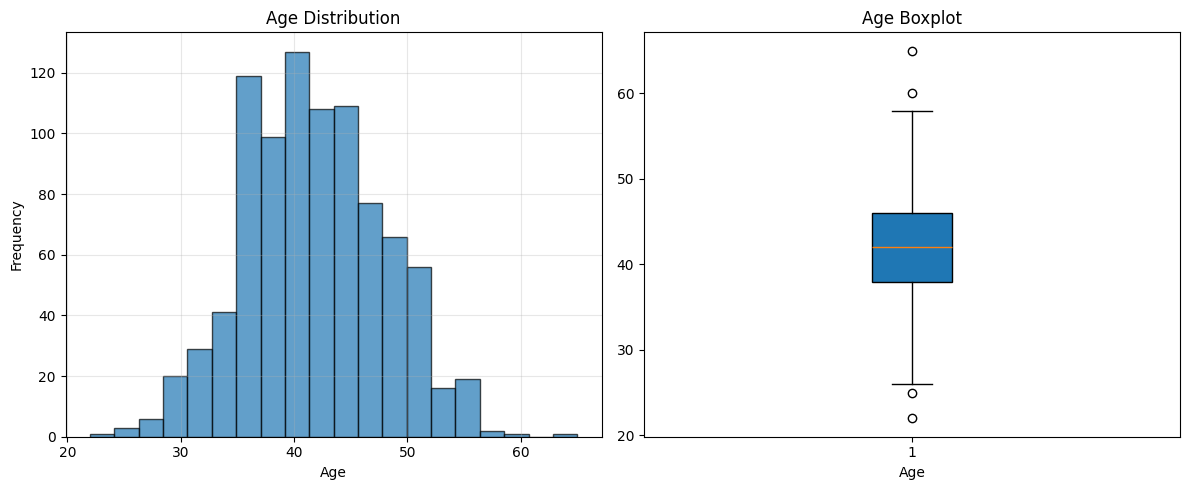

In [1016]:
import matplotlib.pyplot as plt

ages = df.select("Age").rdd.flatMap(lambda x: x).collect()

fig, axes = plt.subplots(1, 2, figsize=(12,5))

# Histogram
axes[0].hist(ages, bins=20, edgecolor='black', alpha=0.7)
axes[0].set_title("Age Distribution")
axes[0].set_xlabel("Age")
axes[0].set_ylabel("Frequency")
axes[0].grid(alpha=0.3)

# Boxplot
axes[1].boxplot(ages, vert=True, patch_artist=True)
axes[1].set_title("Age Boxplot")
axes[1].set_xlabel("Age")

plt.tight_layout()
plt.show()

Podemos ver que la distribución de edad es algo similar a una distribución normal, sin embargo tiene un poco más de agrupación hacia los valores centrales. Tomando esto en cuenta, podemos asumir que los outliers dentro del boxplot se marcan un poco más "agresivamente" y puede que noe stén tan alejados de los valores centrales. Apoyándonos de la distribución, podemos identificar un valor por encima de 60 que podemos remover. Mientras que el resto de outliers parece manterse bastante apegado a los valores "normales".

**Correlación con Variable Objetivo**

/tmp/ipykernel_15713/2877278957.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(data=pdf, x="Churn", y="Age", palette="Set2", inner="quartile")


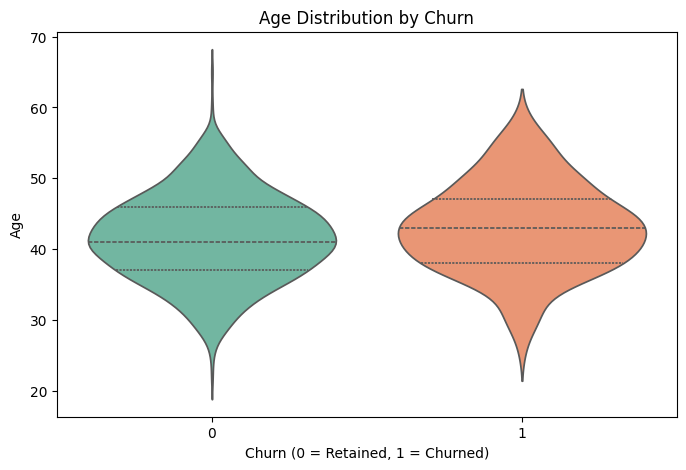

Cohen's d for Age: -0.228


In [1017]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from pyspark.sql.functions import col

# Convert only needed columns to pandas for plotting/stats
pdf = df.select("Age", "Churn").toPandas()

# Violin plot
plt.figure(figsize=(8,5))
sns.violinplot(data=pdf, x="Churn", y="Age", palette="Set2", inner="quartile")
plt.title("Age Distribution by Churn")
plt.xlabel("Churn (0 = Retained, 1 = Churned)")
plt.ylabel("Age")
plt.show()

# Compute Cohen's d (effect size)
ch0 = pdf[pdf["Churn"] == 0]["Age"]
ch1 = pdf[pdf["Churn"] == 1]["Age"]

def cohens_d(a, b):
    diff = np.mean(a) - np.mean(b)
    pooled_std = np.sqrt((np.std(a, ddof=1)**2 + np.std(b, ddof=1)**2) / 2)
    return diff / pooled_std

d_value = cohens_d(ch0, ch1)
print(f"Cohen's d for Age: {d_value:.3f}")

Podemos ver según la gráfica, al igual que el indicador de Cohen que las distribuciones son bastante parecidas. Realmente no hay una diferencia significativa, sin embargo parece indicar que los clientes con mayor edad tienden a abandonar menos. La estrategia que podemos seguir aquí es investigar demás variables explorando colinealidad, y darle prioridad a las demás en caso que necesitemos un modelo con menos variables.

### Total Purchase

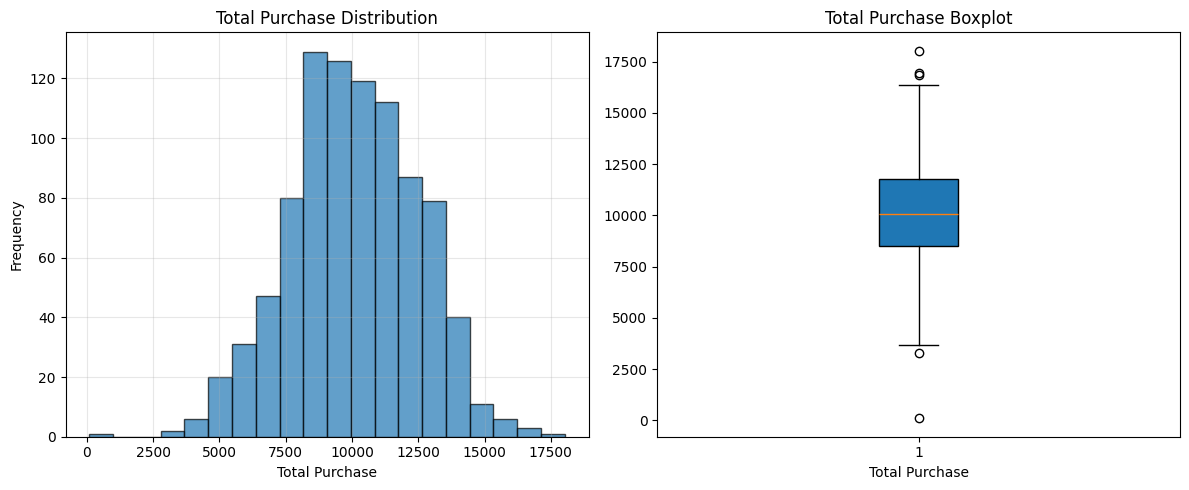

In [1018]:
tp = df.select("Total_Purchase").rdd.flatMap(lambda x: x).collect()

fig, axes = plt.subplots(1, 2, figsize=(12,5))

axes[0].hist(tp, bins=20, edgecolor='black', alpha=0.7)
axes[0].set_title("Total Purchase Distribution")
axes[0].set_xlabel("Total Purchase")
axes[0].set_ylabel("Frequency")
axes[0].grid(alpha=0.3)

axes[1].boxplot(tp, vert=True, patch_artist=True)
axes[1].set_title("Total Purchase Boxplot")
axes[1].set_xlabel("Total Purchase")

plt.tight_layout()
plt.show()

Dentro de las gráficas podemos observar que sigue una distirbución parecida a la normal, sin embargo también nos damos cuenta que cuenta con algunos outliers. El más notorio de ellos, es el valor por debajo de 2500. En este caso, decidimos remover este outlier ya que se encuentra muy cercano a 0 y puede afectar nuestro modelo. En cuanto a los demás outliers, decidimos dejarlos ya que no se encuentran demasiado lejos del rango normal. De momento, no queremos ser demasiado agresivos.

In [1019]:
before = df.count()
df = df.filter(df.Total_Purchase >= 2500)
after = df.count()
print(f"Rows removed: {before - after}")

Rows removed: 1


/tmp/ipykernel_15713/873959840.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(data=pdf, x="Churn", y="Total_Purchase", palette="Set2", inner="quartile")


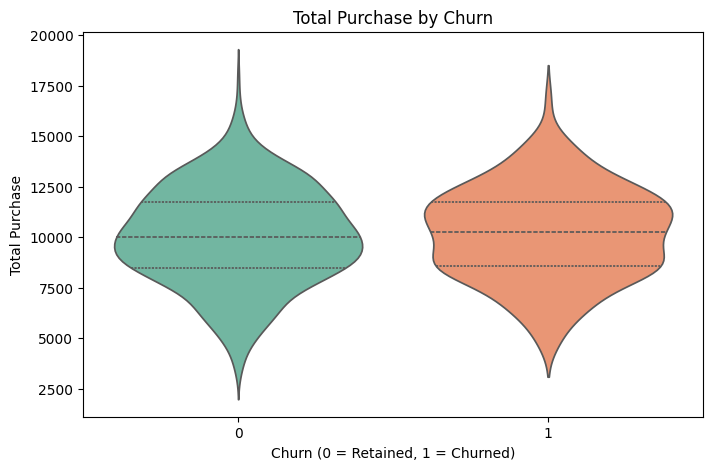

Cohen's d for Total Purchase: -0.060


In [1020]:
# Violin plot by churn
pdf = df.select("Total_Purchase", "Churn").toPandas()

plt.figure(figsize=(8,5))
sns.violinplot(data=pdf, x="Churn", y="Total_Purchase", palette="Set2", inner="quartile")
plt.title("Total Purchase by Churn")
plt.xlabel("Churn (0 = Retained, 1 = Churned)")
plt.ylabel("Total Purchase")
plt.show()

# Compute Cohen's d (effect size)
ch0 = pdf[pdf["Churn"] == 0]["Total_Purchase"]
ch1 = pdf[pdf["Churn"] == 1]["Total_Purchase"]

def cohens_d(a, b):
    diff = np.mean(a) - np.mean(b)
    pooled_std = np.sqrt((np.std(a, ddof=1)**2 + np.std(b, ddof=1)**2) / 2)
    return diff / pooled_std

d_value = cohens_d(ch0, ch1)
print(f"Cohen's d for Total Purchase: {d_value:.3f}")

En este caso, podemos ver que las distribuciones dependiendo de Churn son bastante similares. Observando las medidas dentro de los plots, podemos ver que se encuentran casi lado a lado. Esto nos indica que utilizando únicamente Total Purchase, no existe una correlación directa.

### Years

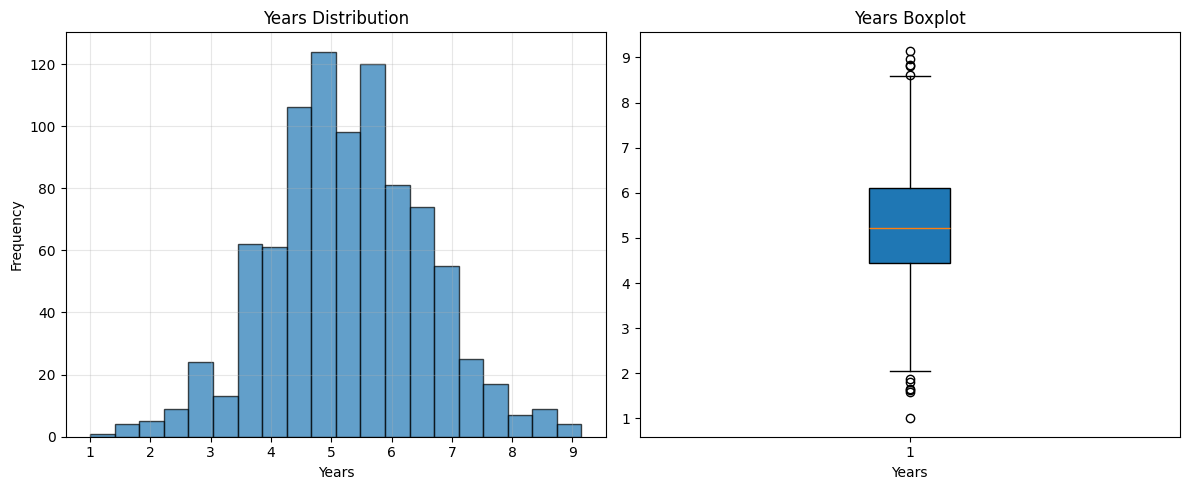

In [1021]:
years = df.select("Years").rdd.flatMap(lambda x: x).collect()

fig, axes = plt.subplots(1, 2, figsize=(12,5))

axes[0].hist(years, bins=20, edgecolor='black', alpha=0.7)
axes[0].set_title("Years Distribution")
axes[0].set_xlabel("Years")
axes[0].set_ylabel("Frequency")
axes[0].grid(alpha=0.3)

axes[1].boxplot(years, vert=True, patch_artist=True)
axes[1].set_title("Years Boxplot")
axes[1].set_xlabel("Years")

plt.tight_layout()
plt.show()

Aquí podemos darnos cuenta que los clientes son relativamente nuevos, los clientes más antiguos llevan unos 9 años con la empresa. Sin embargo, también nos podemos dar cuenta que hay una cantidad consdiderable de "outliers" en el boxplot. Estos clientes con menos de 2 años se encuentran fuera del rango "normal" y representan clientes bastante nuevos. En este caso, vamos a remover estos valores ya que consideramos también que representan clientes que "no han tenido oportunidad de abandonar" y pueden no se representativos del resto de los datos.

In [1022]:
before = df.count()
df = df.filter(df.Years >= 2)
after = df.count()
print(f"Rows removed: {before - after}")

Rows removed: 6


/tmp/ipykernel_15713/1259704260.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(data=pdf, x="Churn", y="Years", palette="Set2", inner="quartile")


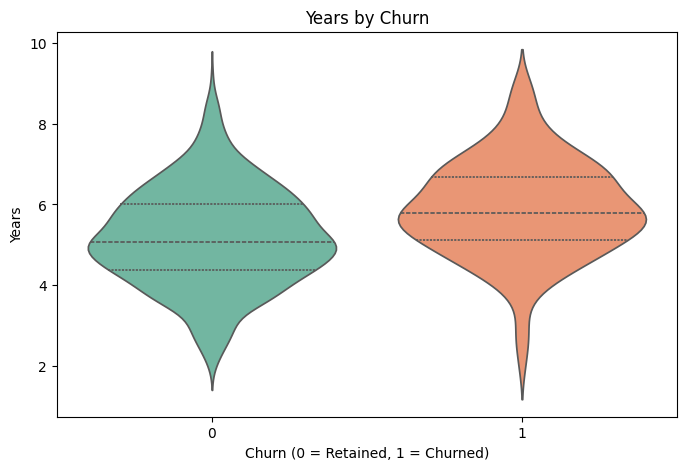

Cohen's d for Years: -0.582


In [1023]:
# Violin plot by churn
pdf = df.select("Years", "Churn").toPandas()

plt.figure(figsize=(8,5))
sns.violinplot(data=pdf, x="Churn", y="Years", palette="Set2", inner="quartile")
plt.title("Years by Churn")
plt.xlabel("Churn (0 = Retained, 1 = Churned)")
plt.ylabel("Years")
plt.show()

# Compute Cohen's d (effect size)
ch0 = pdf[pdf["Churn"] == 0]["Years"]
ch1 = pdf[pdf["Churn"] == 1]["Years"]

def cohens_d(a, b):
    diff = np.mean(a) - np.mean(b)
    pooled_std = np.sqrt((np.std(a, ddof=1)**2 + np.std(b, ddof=1)**2) / 2)
    return diff / pooled_std

d_value = cohens_d(ch0, ch1)
print(f"Cohen's d for Years: {d_value:.3f}")

En este caso, podemos ver dos cosas bastante interesantes. Primero, la mediana y rangos intercuartílicos de clientes que abandonan son significativamente más altos. Adicionalmente, las distribuciones parecen agruparse bastante fuertemente hacia la mediana en ambas distribuciones. Esto nos indica que existe una relación bastante fuerte en los clientes más antiguos abandonando más frecuentemente, apoyados también del coeficiente de Cohen de -0.582

### Num Sites

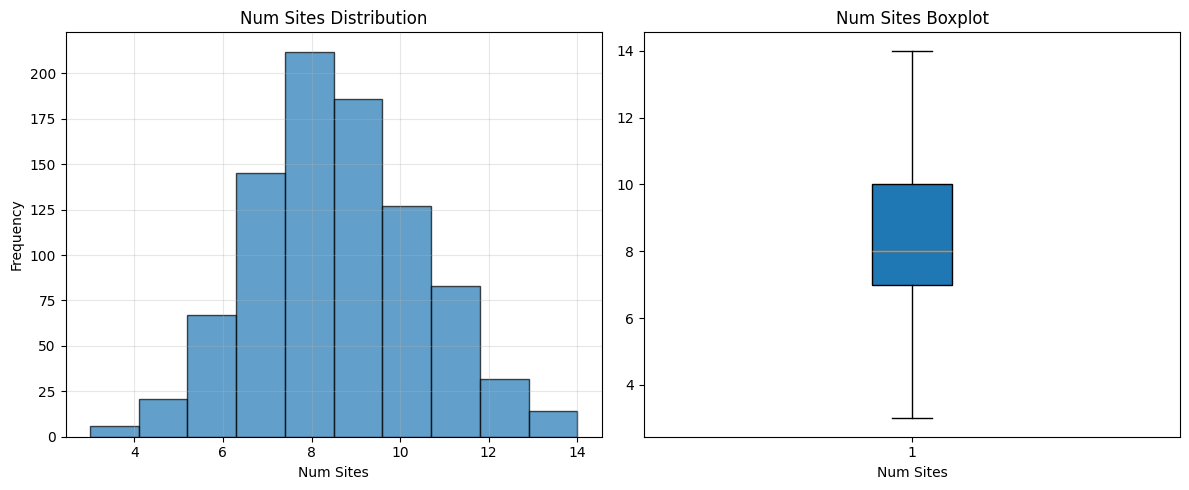

In [1024]:
sites = df.select("Num_Sites").rdd.flatMap(lambda x: x).collect()

fig, axes = plt.subplots(1, 2, figsize=(12,5))

axes[0].hist(sites, edgecolor='black', alpha=0.7)
axes[0].set_title("Num Sites Distribution")
axes[0].set_xlabel("Num Sites")
axes[0].set_ylabel("Frequency")
axes[0].grid(alpha=0.3)

axes[1].boxplot(sites, vert=True, patch_artist=True)
axes[1].set_title("Num Sites Boxplot")
axes[1].set_xlabel("Num Sites")

plt.tight_layout()
plt.show()

Podemos ver que la distribución es bastante cercana a una normal, adicionalmente no tenemos outliers dentro del boxplot. Únicamente podemos observar que una cola es ligeramente más larga que la otra.

/tmp/ipykernel_15713/1535957398.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


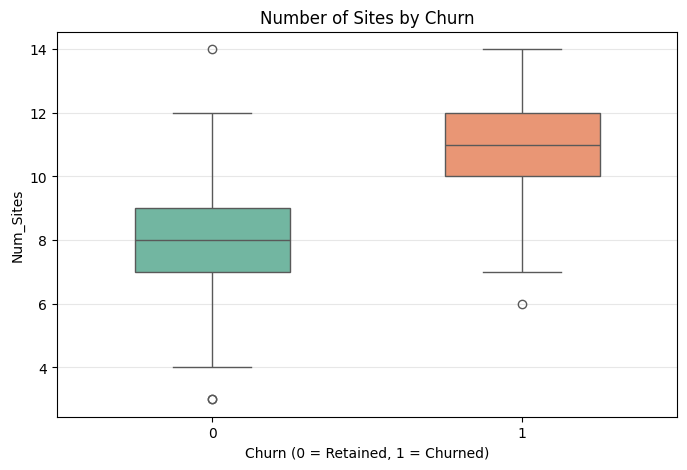

Cohen's d for Onboard Year: -1.670


In [1025]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Convert to pandas
pdf = df.select("Num_Sites", "Churn").toPandas()

plt.figure(figsize=(8,5))
sns.boxplot(
    data=pdf,
    x="Churn",
    y="Num_Sites",
    palette="Set2",
    width=0.5
)
plt.title("Number of Sites by Churn")
plt.xlabel("Churn (0 = Retained, 1 = Churned)")
plt.ylabel("Num_Sites")
plt.grid(axis='y', alpha=0.3)
plt.show()


# Compute Cohen's d (effect size)
ch0 = pdf[pdf["Churn"] == 0]["Num_Sites"]
ch1 = pdf[pdf["Churn"] == 1]["Num_Sites"]

def cohens_d(a, b):
    diff = np.mean(a) - np.mean(b)
    pooled_std = np.sqrt((np.std(a, ddof=1)**2 + np.std(b, ddof=1)**2) / 2)
    return diff / pooled_std

d_value = cohens_d(ch0, ch1)
print(f"Cohen's d for Onboard Year: {d_value:.3f}")

En este caso decidimos utilizar un boxplot, ya que el ViolinPlot era bastante difícil de interpretar al ser números enteros. En este caso, podemos ver una clara diferencia dónde los clientes con una mayor cantidad de sitios tienden a abandonar más frecuentemente. Adicionalmente, tenemos un indicador de Cohen de -1,670, esto nos indica que las distribuciones de las variables hacen overlap con muy poca frecuencia. Hasta el momento es la variable más correlacionada con la variable objetivo, y probablemente sea de las más importantes de incluir dentro de los modelos.

### Onboard Year

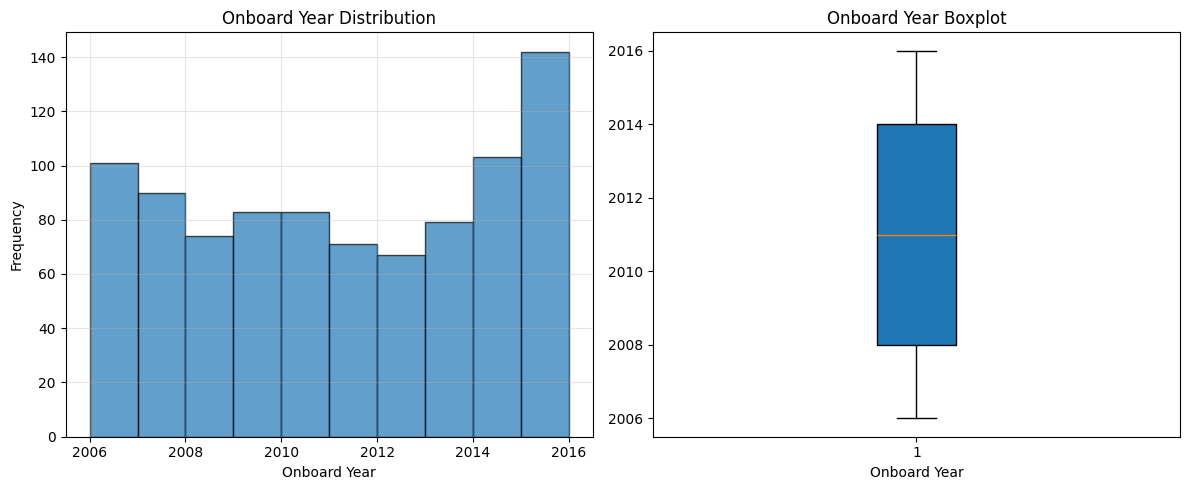

In [1026]:
onboard_years = df.select("Onboard_Year").rdd.flatMap(lambda x: x).collect()

fig, axes = plt.subplots(1, 2, figsize=(12,5))

axes[0].hist(onboard_years, edgecolor='black', alpha=0.7)
axes[0].set_title("Onboard Year Distribution")
axes[0].set_xlabel("Onboard Year")
axes[0].set_ylabel("Frequency")
axes[0].grid(alpha=0.3)

axes[1].boxplot(onboard_years, vert=True, patch_artist=True)
axes[1].set_title("Onboard Year Boxplot")
axes[1].set_xlabel("Onboard Year")

plt.tight_layout()
plt.show()

En la gráfica podemos ver que la distribución es bastante uniforme a lo largo de los años, únicamente 2016 resalta al tener una alta cantidad de introducciones de clientes.

/tmp/ipykernel_15713/1764291241.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(data=pdf, x="Churn", y="Onboard_Year", palette="Set2", inner="quartile")


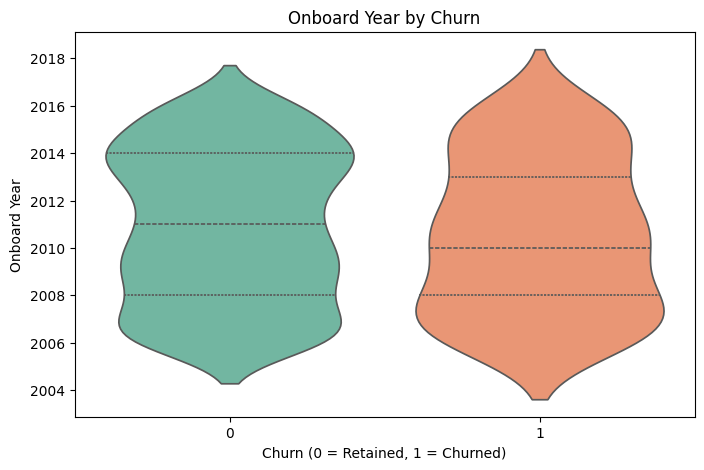

Cohen's d for Onboard Year: 0.112


In [1027]:
# Violin plot by churn
pdf = df.select("Onboard_Year", "Churn").toPandas()

plt.figure(figsize=(8,5))
sns.violinplot(data=pdf, x="Churn", y="Onboard_Year", palette="Set2", inner="quartile")
plt.title("Onboard Year by Churn")
plt.xlabel("Churn (0 = Retained, 1 = Churned)")
plt.ylabel("Onboard Year")
plt.show()

# Compute Cohen's d (effect size)
ch0 = pdf[pdf["Churn"] == 0]["Onboard_Year"]
ch1 = pdf[pdf["Churn"] == 1]["Onboard_Year"]

def cohens_d(a, b):
    diff = np.mean(a) - np.mean(b)
    pooled_std = np.sqrt((np.std(a, ddof=1)**2 + np.std(b, ddof=1)**2) / 2)
    return diff / pooled_std

d_value = cohens_d(ch0, ch1)
print(f"Cohen's d for Onboard Year: {d_value:.3f}")

Continuando el análisis, tenemos un indicador de Cohen bastante bajo y las distribuciones parecen contener valores bastante variados. Puede ser que en conjunto con otras variables pueda predecir el Churn, sin embargo de momento no parece existir relación alguna.

### Correlación entre Variables Numéricas
Aquí vamos a explorar la correlación entre algunas de nuestras variables, simplemente utilizando una matriz de correlación podemos tener una referencia para remover / unir diferentes variables para nuestro modelo.

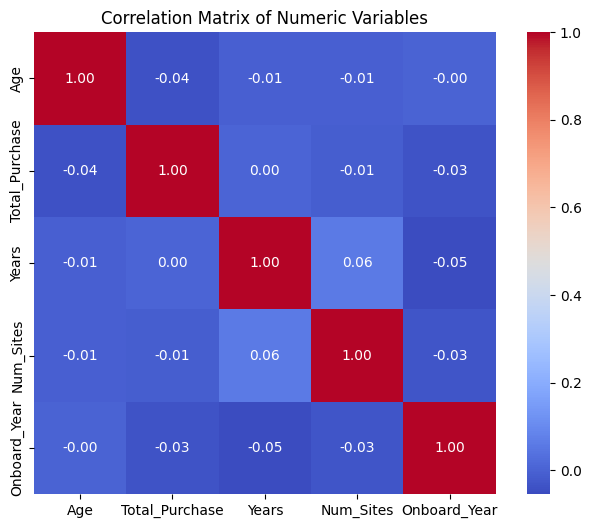

In [1028]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

pdf = df.select("Age", "Total_Purchase", "Years", "Num_Sites", "Onboard_Year").toPandas()

# Compute correlation matrix
corr = pdf.corr()

# Plot correlation heatmap
plt.figure(figsize=(8,6))
sns.heatmap(
    corr,
    annot=True,
    fmt=".2f",
    cmap="coolwarm",
    square=True
)
plt.title("Correlation Matrix of Numeric Variables")
plt.show()

Podemos ver que realmente no existe correlación alguna entre nuestras variables numéricas, esto nos simplifica bastante el fine-tuning del modelo. Al no tenernos que preocupar por colinealidad, podemos únicamente ir removiendo variables menos influyentes y variando parámetros.

### Variables Categóricas

/tmp/ipykernel_15713/2994262995.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=pdf_state, x="State", y="count", palette="crest")


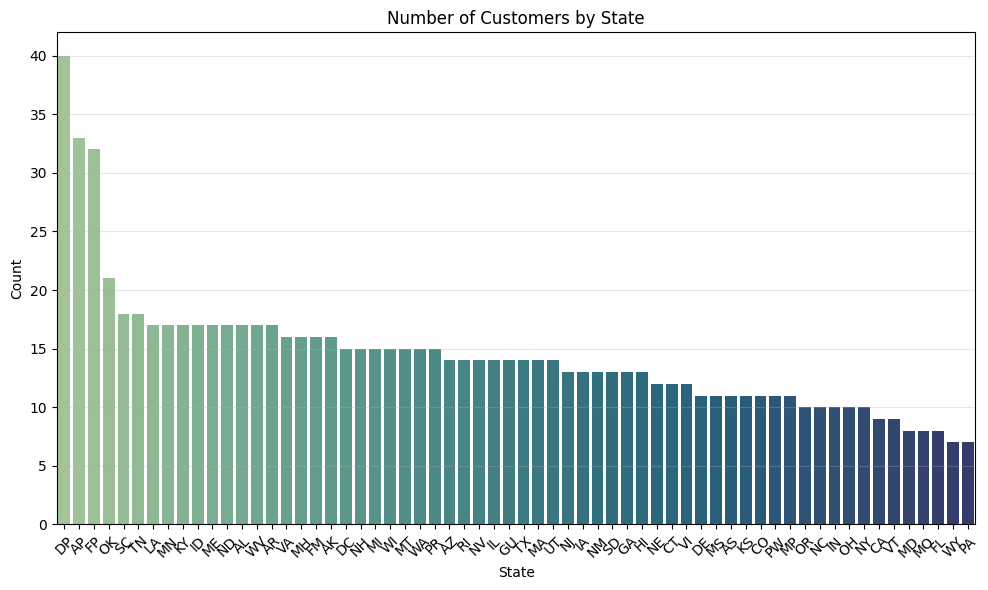

In [1029]:
import matplotlib.pyplot as plt
import seaborn as sns
from pyspark.sql import functions as F

df = df.withColumn(
    "State",
    when((col("State").isNull()) | (col("State") == ""), "Unknown").otherwise(col("State"))
)

pdf_state = (
    df.groupBy("State")
      .agg(F.count("*").alias("count"))
      .orderBy(F.desc("count"))
      .toPandas()
)

# Plot bar chart
plt.figure(figsize=(10,6))
sns.barplot(data=pdf_state, x="State", y="count", palette="crest")
plt.title("Number of Customers by State")
plt.xlabel("State")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.grid(axis="y", alpha=0.3)
plt.tight_layout()
plt.show()

Podemos ver que la mayoría de estados tenemos una cantidad similar de clientes, sin embargo tenemos DP, AP y FP con cantidades más altas. Estos son "pseudoestados" que se refieren a direcciones diplomáticas o militares en Estados Unidos.

### Test / Train y Preprocesamiento

Primero, vamos a separar los splits de Train / Test. Adicionalmente, vamos a utilizar oversampling para manejar el desbalance de clases.

In [1030]:
from pyspark.sql.functions import when, col
from pyspark.ml.feature import (
    StringIndexer, OneHotEncoder, VectorAssembler, StandardScaler
)
from pyspark.ml.classification import LogisticRegression
from pyspark.ml import Pipeline

churn_0 = df.filter(col("Churn") == 0)
churn_1 = df.filter(col("Churn") == 1)

train_0, test_0 = churn_0.randomSplit([0.8, 0.2], seed=42)
train_1, test_1 = churn_1.randomSplit([0.8, 0.2], seed=42)

train_df = train_0.union(train_1)
test_df = test_0.union(test_1)

# compute weights
counts = train_df.groupBy("Churn").count().collect()
n0 = counts[0]["count"]
n1 = counts[1]["count"]
total = n0 + n1
w0 = total / (2.0 * n0)
w1 = total / (2.0 * n1)

train_df = train_df.withColumn("weight", when(col("Churn") == 0, w0).otherwise(w1))

train_df.groupBy("Churn").count().show()
test_df.groupBy("Churn").count().show()

+-----+-----+
|Churn|count|
+-----+-----+
|    0|  624|
|    1|  126|
+-----+-----+

+-----+-----+
|Churn|count|
+-----+-----+
|    0|  119|
|    1|   24|
+-----+-----+



Ahora, podemos tomar las columnas y encodearlas.

In [1031]:

numeric_cols = ["Age", "Total_Purchase", "Account_Manager", "Years", "Num_Sites"]
categorical_cols = ["State"]
label_col = "Churn"

indexers = [StringIndexer(inputCol=c, outputCol=f"{c}_index", handleInvalid="keep") for c in categorical_cols]
encoders = [OneHotEncoder(inputCols=[f"{c}_index"], outputCols=[f"{c}_ohe"]) for c in categorical_cols]

numeric_assembler = VectorAssembler(inputCols=numeric_cols, outputCol="numeric_features")
scaler = StandardScaler(inputCol="numeric_features", outputCol="scaled_numeric", withMean=True, withStd=True)

feature_inputs = ["scaled_numeric"] + [f"{c}_ohe" for c in categorical_cols]
assembler_final = VectorAssembler(inputCols=feature_inputs, outputCol="features")

preprocess_pipeline = Pipeline(stages=indexers + encoders + [numeric_assembler, scaler, assembler_final])
preprocessor = preprocess_pipeline.fit(train_df)

train_prepared = preprocessor.transform(train_df)
test_prepared = preprocessor.transform(test_df)

train_prepared.select("features", label_col).show(5, truncate=False)

+-----------------------------------------------------------------------------------------------------------------------------+-----+
|features                                                                                                                     |Churn|
+-----------------------------------------------------------------------------------------------------------------------------+-----+
|(67,[0,1,2,3,4,26],[-3.242949728199427,0.5165314104402766,1.0457112910756268,-0.26711198986567586,-0.34119978511450627,1.0]) |0    |
|(67,[0,1,2,3,4,5],[-2.753931774412904,-0.15022014066244718,-0.9550118423598837,0.1566130319700873,-0.34119978511450627,1.0]) |0    |
|(67,[0,1,2,3,4,47],[-2.427919805221889,-0.5898038109357092,1.0457112910756268,0.004711609047832347,-0.9162556027232089,1.0]) |0    |
|(67,[0,1,2,3,4,45],[-2.2649138206263815,-0.5720305114599212,-0.9550118423598837,-1.0426087279424494,-1.4913114203319116,1.0])|0    |
|(67,[0,1,2,3,4,54],[-2.2649138206263815,-0.3952877313480381,1

## Modelo Baseline
Para el modelo baseline, vamos a aplicar una regresión logística con los parámetros por defecto para realizar predicciones

In [1032]:
lr = LogisticRegression(featuresCol="features", labelCol=label_col, weightCol="weight")
model = lr.fit(train_prepared)

predictions = model.transform(test_prepared)

### Matriz de Confusión

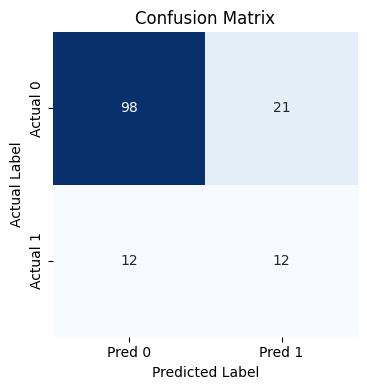

              precision    recall  f1-score   support

           0      0.891     0.824     0.856       119
           1      0.364     0.500     0.421        24

    accuracy                          0.769       143
   macro avg      0.627     0.662     0.638       143
weighted avg      0.802     0.769     0.783       143



In [1033]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
import pandas as pd

pdf_preds = predictions.select("Churn", "prediction").toPandas()

cm = confusion_matrix(pdf_preds["Churn"], pdf_preds["prediction"])
cm_df = pd.DataFrame(cm, index=["Actual 0", "Actual 1"], columns=["Pred 0", "Pred 1"])


plt.figure(figsize=(6,4))
sns.heatmap(cm_df, annot=True, fmt="d", cmap="Blues", cbar=False, square=True)
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("Actual Label")
plt.tight_layout()
plt.show()

print(classification_report(pdf_preds["Churn"], pdf_preds["prediction"], digits=3))


Podemos ver según la matriz de confusión que el modelo realmente no es muy efectivo, el recall es de únicamente 0.5 para el churn=1 y la precisión es sumamente baja. Adicionalmente, sufre de sobre predecir la clase mayoritaria.

### ROC-AUC

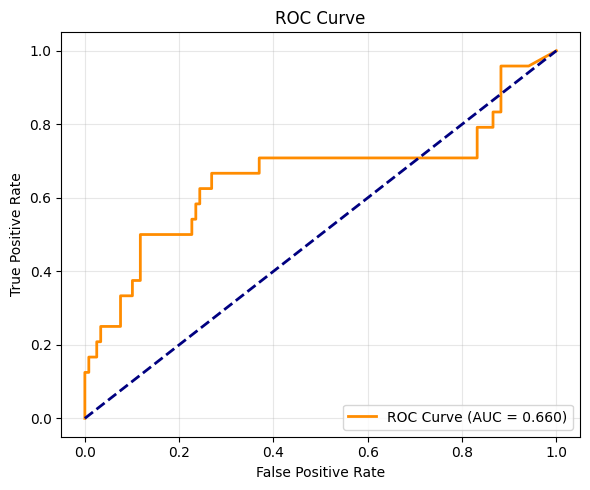

In [1034]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score
import pandas as pd

pdf_preds = predictions.select("Churn", "probability").toPandas()
pdf_preds["prob_1"] = pdf_preds["probability"].apply(lambda x: float(x[1]))

fpr, tpr, _ = roc_curve(pdf_preds["Churn"], pdf_preds["prob_1"])
auc = roc_auc_score(pdf_preds["Churn"], pdf_preds["prob_1"])

plt.figure(figsize=(6,5))
plt.plot(fpr, tpr, color="darkorange", lw=2, label=f"ROC Curve (AUC = {auc:.3f})")
plt.plot([0, 1], [0, 1], color="navy", lw=2, linestyle="--")
plt.title("ROC Curve")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="lower right")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

Según la curva ROC, el modelo tiene un rendimiento bastante similar a un modelo aleatorio. Realmente un ROC-AUC de 0.660 es bastante malo para lo que buscamos predecir con el modelo. Según lo que vimos en el EDA, puede ser porque estamos utilizando muchas variables poco correlacionadas con la variable objetivo. Podemos realizar un análisis de pesos de cada variable para verificarlo

In [1035]:
import pandas as pd
import numpy as np

num_feats = ["Age", "Total_Purchase", "Account_Manager", "Years", "Num_Sites"]
cat_feats = preprocessor.stages[0].labels if "State" in df.columns else []
feature_names = num_feats + [f"State_{c}" for c in cat_feats]

coefs = model.coefficients.toArray()
odds = np.exp(coefs)

feat_df = pd.DataFrame({
    "Feature": feature_names,
    "Coefficient": coefs,
    "Abs_Coefficient": np.abs(coefs),
    "Odds_Ratio": odds
}).sort_values(by="Abs_Coefficient", ascending=True)

display(feat_df.style.format({
    "Coefficient": "{:.3f}",
    "Abs_Coefficient": "{:.3f}",
    "Odds_Ratio": "{:.3f}"
}))


,Feature,Coefficient,Abs_Coefficient,Odds_Ratio
52,State_VT,0.065,0.065,1.067
59,State_NY,0.111,0.111,1.118
1,Total_Purchase,0.193,0.193,1.213
35,State_ID,0.296,0.296,1.344
2,Account_Manager,0.359,0.359,1.431
14,State_ME,0.395,0.395,1.485
0,Age,0.437,0.437,1.548
43,State_NV,0.529,0.529,1.697
42,State_KS,0.636,0.636,1.890
57,State_MD,0.661,0.661,1.936


Según el output, tenemos muchas variables con coeficientes súmamente bajos. Esto nos indica que hay demasiada "basura" en nuestro modelo que necesitamos remover. Podemos explorar utilizando Lasso para remover variables poco influyentes.

## Lasso
En este inciso vamos a utilizar Lasso puro para remover de manera agresiva las variables poco significativas, esto ya que varias parecen estar agregando "ruido" a neustro modelo. Adicionalmente, un modelo con menos variables es más fácil de entender y explicar.

In [ ]:
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.evaluation import BinaryClassificationEvaluator

lr = LogisticRegression(
    featuresCol="features",
    labelCol=label_col,
    weightCol="weight",
    regParam=0.1,
    elasticNetParam=1.0
)

model = lr.fit(train_prepared)
predictions = model.transform(test_prepared)

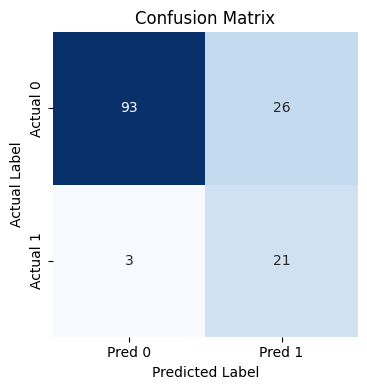

              precision    recall  f1-score   support

           0      0.969     0.782     0.865       119
           1      0.447     0.875     0.592        24

    accuracy                          0.797       143
   macro avg      0.708     0.828     0.728       143
weighted avg      0.881     0.797     0.819       143



In [1037]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
import pandas as pd

pdf_preds = predictions.select("Churn", "prediction").toPandas()

cm = confusion_matrix(pdf_preds["Churn"], pdf_preds["prediction"])
cm_df = pd.DataFrame(cm, index=["Actual 0", "Actual 1"], columns=["Pred 0", "Pred 1"])


plt.figure(figsize=(6,4))
sns.heatmap(cm_df, annot=True, fmt="d", cmap="Blues", cbar=False, square=True)
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("Actual Label")
plt.tight_layout()
plt.show()

print(classification_report(pdf_preds["Churn"], pdf_preds["prediction"], digits=3))

Observando la matriz de confusión, logramos darnos cuenta que el modelo es una mejora significativa en comparación al anterior. En este caso, el recall de Churn=1 es de 0.875, lo cuál es la métrica en la que más deberíamos enfocarnos. Esta es la que realmente nos indica que tanto el modelo "se da cuenta que un cliente se va a ir". Adicionalmente, las métricas como F1 weighted de 0.82 son bastante prometedoras. Para continuar nuestro análisis, podemos continuar con la curva ROC AUC

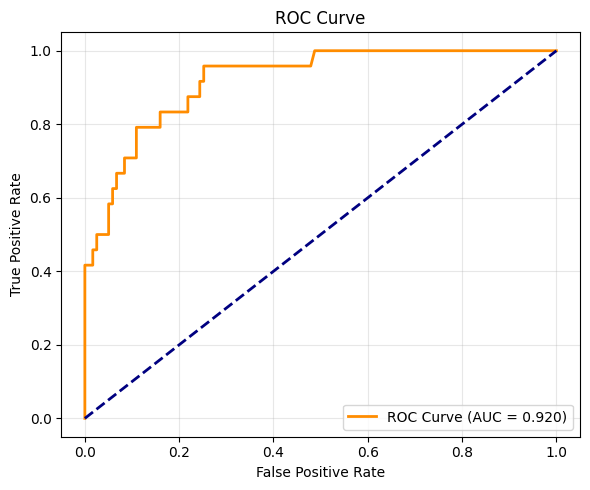

In [1038]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score
import pandas as pd

pdf_preds = predictions.select("Churn", "probability").toPandas()
pdf_preds["prob_1"] = pdf_preds["probability"].apply(lambda x: float(x[1]))

fpr, tpr, _ = roc_curve(pdf_preds["Churn"], pdf_preds["prob_1"])
auc = roc_auc_score(pdf_preds["Churn"], pdf_preds["prob_1"])

plt.figure(figsize=(6,5))
plt.plot(fpr, tpr, color="darkorange", lw=2, label=f"ROC Curve (AUC = {auc:.3f})")
plt.plot([0, 1], [0, 1], color="navy", lw=2, linestyle="--")
plt.title("ROC Curve")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="lower right")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

Podemos ver un ROC AUC de 0.920, esto es bastante bueno. Viendo la curva, se encuentra bastante por encima de un modelo aleatorio y cerca de un modelo "perfecto". En este caso, podemos decir que el modelo es un éxito y logra predecir de manera correcta los clientes que van a abandonar la empresa.

In [1039]:
import pandas as pd
import numpy as np

num_feats = ["Age", "Total_Purchase", "Account_Manager", "Years", "Num_Sites"]
cat_feats = preprocessor.stages[0].labels if "State" in df.columns else []
feature_names = num_feats + [f"State_{c}" for c in cat_feats]

coefs = model.coefficients.toArray()
odds = np.exp(coefs)

feat_df = pd.DataFrame({
    "Feature": feature_names,
    "Coefficient": coefs,
    "Abs_Coefficient": np.abs(coefs),
    "Odds_Ratio": odds
}).sort_values(by="Abs_Coefficient", ascending=False)

display(feat_df.style.format({
    "Coefficient": "{:.3f}",
    "Abs_Coefficient": "{:.3f}",
    "Odds_Ratio": "{:.3f}"
}))

,Feature,Coefficient,Abs_Coefficient,Odds_Ratio
4,Num_Sites,0.929,0.929,2.533
3,Years,0.119,0.119,1.127
0,Age,0.000,0.000,1.000
2,Account_Manager,0.000,0.000,1.000
1,Total_Purchase,0.000,0.000,1.000
5,State_DP,0.000,0.000,1.000
6,State_FP,0.000,0.000,1.000
7,State_AP,0.000,0.000,1.000
8,State_TN,0.000,0.000,1.000
9,State_MN,0.000,0.000,1.000


Esta tabla lo que nos indica, es que únicamente está utilizando dos variables. Esto es un poco de esperarse, al utilizar un Lasso sumamente agresivo. Esto nos puede servir como una ejemplificación del dicho "GIGO", Garbage In Garbage Out. Dónde algunas variables (cómo lo pueden ser Estados extraídos de las direcciones) simplemente agregan ruido al tener un dataset pequeño y resultan en predicciones erróneas. En general, la aplicación de Lasso fue un éxito y logró aumentar el desempeño del modelo significativamente.

## Clientes Nuevos con Mejor Modelo

In [1042]:
new_clients_prepared = preprocessor.transform(df_nuevos)

new_predictions = model.transform(new_clients_prepared)

new_predictions.select(
    "Company",
    "Account_Manager",
    "probability",
    "prediction"
).show(truncate=False)

+----------------+---------------+----------------------------------------+----------+
|Company         |Account_Manager|probability                             |prediction|
+----------------+---------------+----------------------------------------+----------+
|King Ltd        |1              |[0.6325576625344382,0.36744233746556176]|0.0       |
|Cannon-Benson   |1              |[0.033955900958852044,0.966044099041148]|1.0       |
|Barron-Robertson|1              |[0.07187063630553336,0.9281293636944666]|1.0       |
|Sexton-Golden   |0              |[0.05598377489052931,0.9440162251094707]|1.0       |
|Wood LLC        |1              |[0.580483355967071,0.419516644032929]   |0.0       |
|Parks-Robbins   |1              |[0.0946226805595286,0.9053773194404714] |1.0       |
+----------------+---------------+----------------------------------------+----------+



Aquí podemos ver que el modelo predice a Cannon-Benson, Barron-Ronertson, Sexton-Golden y Parks-Robbins yéndose de la empresa. Adicionalmente, nos podemos dar cuenta que algunos de los clientes ya cuentan con un Account Manager a pesar de ser probables de abandonar. Basados en la probabilidad dada por el modelo (del lado derecho de la columna de probability), podemos recomendar que se les asigne un manejador de cuenta a Sexton Golden de manera urgente. Adicionalmente, recomendamos identificar diferentes maneras de mantener clientes más grandes, ya que la mayoría de compañías que deciden abandonar la empresa tienen más sitios y más años. Las variables significativas son "consecuencias naturales", por lo que podemos utilizar nuestros modelos únicamente para advertir y no necesariamente prevenir el churn. Si la empresa considera que el Account Manager ayuda con esto, esa es nuestra recomendación.

## Conclusiones y Recomendaciones

### Conclusiones
- El modelo de regresión logística implementado es capaz de resolver este problema, identificando correctamente los clientes que abandonan la empresa.
- En algunos casos es una buena idea mantener las variables incluidas dentro del modelo mínimas, al tener variables "basura" que realmente no contribuyen únicamente se confunde al modelo buscando relaciones dónde no hay.
- Lasso es una técnica bastante útil para remvoer variables que no contribuyen al modelo-

### Recomendaciones
- Explorar diferentes transformaciones de variables, por ejemplo direcciones y estados se podría implementar geolocalización. En nuestro caso, extraer únicamente los estados no comprobó ser útil para el modelo.
- Probar otras técnicas de regularización menos agresivas, puede que existan demás variables útiles para el modelo a parte de las incluidas.
- Explorar diferentes modelos para la clasificación, dentro de este laboratorio implementamos únicamente regresión logística pero puede que existan relaciones un poco más complejas que puedan ser captada por otros modelos.